In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
np.random.seed(0)

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate
n_worms = len(tseries_w)
len_w,dim = tseries_w[0].shape

In [3]:
n_clusters=1000

f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

labels_traj_w = labels_traj.reshape((n_worms,len_w))

In [4]:
def plot_hist_modes(tseries_sim_random,tseries_data,mode_idx,bins=50):
    if mode_idx==0:
        x_range = np.linspace(-14,14,bins)
    elif mode_idx == 1:
        x_range = np.linspace(-14,14,bins)
    elif mode_idx == 2:
        x_range = np.linspace(-25,25,bins)
    elif mode_idx == 3:
        x_range = np.linspace(-10,10,bins)
    elif mode_idx == 4:
        x_range = np.linspace(-5,5,bins)
        
    freqs_sim,bins_sim = np.histogram(tseries_sim_random,bins=x_range)
    centers = (bins_sim[1:]+bins_sim[:-1])/2
    freqs_data,bins_data = np.histogram(tseries_data,bins=x_range)
    return centers,freqs_data/np.trapz(freqs_data,centers),freqs_sim/np.trapz(freqs_sim,centers)

In [5]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [6]:
n_samples=100000
n_bins=30
p_data_mode = []
p_sim_mode=[]
centers_mode = []
for mode_idx in range(5):
    p_data_w = []
    p_sim_w = []
    for kw in range(n_worms):
        f = h5py.File("../data/tseries_sims/tseries_sims_{}.h5".format(kw),'r')
        all_sims = ma.vstack(ma.array(f['ts_smooth_sims']))[:,mode_idx]
        f.close()
        all_sims[all_sims==0] = ma.masked
        all_sims = all_sims.compressed()
        ts_sim_random = all_sims[np.random.randint(0,len(all_sims),n_samples)]
        centers,p_data,p_sim = plot_hist_modes(ts_sim_random,tseries_w[kw][:,mode_idx].compressed(),mode_idx,bins=n_bins)
        p_data_w.append(p_data)
        p_sim_w.append(p_sim)
    p_data_mode.append(p_data_w)
    p_sim_mode.append(p_sim_w)
    centers_mode.append(centers)
    print(mode_idx)

0
1
2
3
4


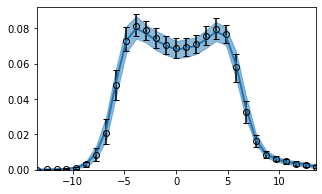

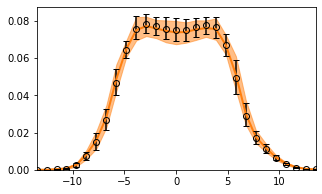

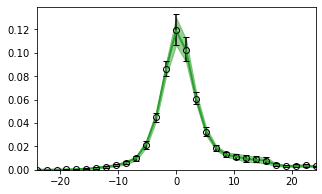

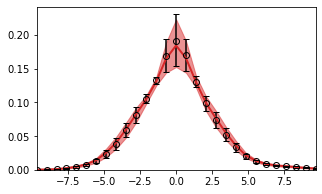

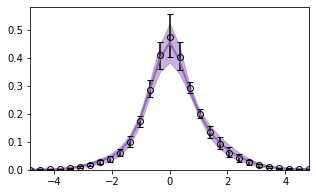

In [7]:
for mode_idx in range(5):
    p_data_w = p_data_mode[mode_idx]
    p_sim_w = p_sim_mode[mode_idx]
    centers = centers_mode[mode_idx]
    mean,cil,ciu = stats.bootstrap(p_data_w,n_times=1000)
    mean_sim,cil_sim,ciu_sim = stats.bootstrap(p_sim_w,n_times=1000)
    plt.figure(figsize=(5,3))
    plt.plot(centers,mean,c=colors_state_[mode_idx],lw=2)
    plt.fill_between(centers,cil,ciu,alpha=.5,color=colors_state_[mode_idx])
    plt.errorbar(centers,mean_sim,yerr = [mean_sim-cil_sim,ciu_sim-mean_sim],c='k',fmt='o',mfc='none',capsize=3)
    plt.xlim(centers[0],centers[-1])
    plt.ylim(0,)
#     plt.savefig('mode_dist_all_worms_mode_{}_errorbars.pdf'.format(mode_idx))
    plt.show()

# Prediction errors

In [8]:
sim_interp_ts_w =[]
for kw in range(n_worms):
    f = h5py.File("../data/tseries_sims/tseries_sims_{}.h5".format(kw),'r')
    sim_interp = ma.array(f['ts_interp_sims'])
    f.close()
    sim_interp_ts_w.append(sim_interp)

In [9]:
n_sims=1000
n_samples=10000
wsize = int(20*frameRate)
eps_t = ma.zeros((n_samples,wsize))
for k in range(n_samples):
    kw = np.random.randint(n_worms)
    ks=np.random.randint(0,n_sims)
    #use interpolated tseries because the smoothed can deviate at t=0 more than the partition size
    #making it an unfair comparison with the real data
    sim_interp = sim_interp_ts_w[kw][ks] 
    sim_interp[sim_interp==0] = ma.masked
    
    possible_indices = np.arange(0,len(sim_interp)-wsize)
    
    t0=len(tseries_w[kw])
    while t0>len(tseries_w[kw])-wsize:
        sim_t0 = np.random.choice(possible_indices)
        ts0 = sim_interp[sim_t0]
        t0 = np.argmin(((tseries_w[kw]-ts0)**2).sum(axis=1))
    eps_t[k] = ma.sqrt(((sim_interp[sim_t0:sim_t0+wsize] - tseries_w[kw][t0:t0+wsize])**2).sum(axis=1))
    if k%10==0:
        print(k,kw,ks)

0 7 85
10 4 664
20 8 740
30 8 628
40 9 633
50 0 879
60 3 877
70 6 637
80 10 161
90 9 132
100 8 259
110 9 169
120 7 168
130 0 291
140 1 152
150 1 90
160 1 536
170 10 618
180 5 261
190 3 617
200 1 284
210 6 788
220 6 461
230 2 237
240 9 568
250 9 313
260 1 164
270 4 493
280 7 755
290 9 731
300 0 623
310 10 169
320 11 430
330 10 706
340 6 535
350 4 924
360 0 225
370 2 381
380 0 274
390 0 284
400 4 226
410 3 496
420 10 140
430 11 693
440 10 91
450 8 90
460 3 210
470 10 146
480 0 435
490 3 912
500 11 952
510 5 580
520 9 24
530 11 983
540 5 893
550 2 510
560 2 145
570 11 695
580 11 11
590 2 950
600 8 44
610 0 861
620 0 882
630 11 509
640 9 548
650 1 554
660 3 460
670 7 685
680 3 669
690 11 332
700 11 439
710 0 896
720 6 849
730 8 295
740 8 908
750 9 49
760 3 228
770 10 343
780 9 417
790 1 799
800 0 76
810 8 44
820 0 232
830 5 988
840 5 453
850 10 145
860 8 741
870 4 103
880 5 718
890 11 363
900 10 592
910 0 554
920 5 919
930 7 48
940 5 43
950 8 908
960 9 840
970 11 581
980 0 24
990 6 0
1000 

7520 2 35
7530 8 770
7540 7 144
7550 1 779
7560 4 686
7570 3 473
7580 3 188
7590 4 14
7600 2 223
7610 2 726
7620 4 461
7630 1 640
7640 9 265
7650 3 18
7660 1 393
7670 2 502
7680 1 113
7690 7 511
7700 2 799
7710 11 136
7720 1 595
7730 9 63
7740 2 754
7750 3 376
7760 2 368
7770 3 489
7780 0 666
7790 2 873
7800 5 907
7810 1 842
7820 4 855
7830 1 578
7840 7 727
7850 5 711
7860 7 45
7870 4 256
7880 3 507
7890 4 30
7900 7 41
7910 10 486
7920 4 809
7930 10 62
7940 8 580
7950 9 657
7960 3 691
7970 4 670
7980 6 227
7990 2 500
8000 9 67
8010 2 476
8020 9 863
8030 0 312
8040 8 97
8050 7 372
8060 6 388
8070 7 163
8080 5 328
8090 10 110
8100 1 790
8110 11 717
8120 3 266
8130 6 768
8140 3 963
8150 4 796
8160 4 216
8170 3 481
8180 6 661
8190 8 432
8200 10 188
8210 3 919
8220 10 320
8230 1 761
8240 2 895
8250 4 404
8260 0 266
8270 9 327
8280 7 559
8290 0 6
8300 1 924
8310 1 308
8320 5 671
8330 4 578
8340 7 1
8350 8 799
8360 9 297
8370 5 960
8380 0 956
8390 3 571
8400 7 65
8410 10 975
8420 5 264
8430 7

In [10]:
mean,cil,ciu = stats.bootstrap(eps_t,n_times=100)

In [11]:
n_sims=1000
n_random_samples=50000
random_dists = ma.zeros(n_random_samples)
for k in range(n_random_samples):
    kw = np.random.randint(n_worms)
    ts_samples = np.random.randint(0,len_w,2)
    random_dists[k] = ma.sqrt(((tseries_w[kw][ts_samples[0]]-tseries_w[kw][ts_samples[1]])**2).sum())

In [12]:
thresh=0.95*random_dists.mean()
print(thresh)

10.900491092162495


In [13]:
mean_tau_sim = np.where((eps_t.mean(axis=0)-thresh)>0)[0][0]*dt
n_boot=1000
dts_samples = np.array([np.where((eps_t[np.random.randint(0,n_samples,n_samples)].mean(axis=0)-thresh)>0)[0][0]*dt for k in range(n_boot)])
cil_tau_sim = np.percentile(dts_samples,2.5)
ciu_tau_sim = np.percentile(dts_samples,97.5)

# data neighbor in sample partition

In [14]:
eps_data_t = ma.zeros((n_samples,wsize))
for k in range(n_samples):
    kw = np.random.randint(n_worms)
    label0 = np.random.choice(labels_traj_w[kw][:-wsize])
    possible_times = np.arange(len_w-wsize)[labels_traj_w[kw][:-wsize] == label0]

    random_t0 = np.random.choice(possible_times)
    sel = np.abs(possible_times-random_t0)>wsize
    if sel.sum()>0:
        random_t1 = np.random.choice(possible_times[sel])
        random_t0s = np.array([random_t0,random_t1])
        
        ts1 = tseries_w[kw][random_t0s[0]:random_t0s[0]+wsize]
        ts2 = tseries_w[kw][random_t0s[1]:random_t0s[1]+wsize]
        eps_data_t[k] = ma.sqrt(((ts1-ts2)**2).sum(axis=1))
    else:
        print('Could not find pair in ', possible_times)
        continue
    if k%10==0:
        print(k)
eps_data_t[eps_data_t==0] = ma.masked

3
11
7
8
Could not find pair in  [15304 15305 15306]
4
4
1
0
Could not find pair in  [6361 6362 6363]
1
3
Could not find pair in  [6617 6618 6619]
10
9
7
0
4
4
11
9
11
0
3
9
1
4
7
1
1
1
4
5
3
9
10
3
8
11
2
6
7
0
4
9
Could not find pair in  [2941 2942 2943 2944 2945]
10
6
11
9
4
11
1
3
4
8
2
8
4
2
Could not find pair in  [12631 12632 12633 12634 12635 12636]
8
4
6
4
1
0
0
8
Could not find pair in  [8275 8276 8277 8278 8279 8280 8281 8304 8305 8306]
7
7
10
0
8
Could not find pair in  [2768 2769]
7
1
Could not find pair in  [7211 7212]
3
1
10
2
4
10
3
5
6
8
3
6
6
10
6
6
2
3
3
7
11
9
2
9
6
8
2
11
11
1
8
3
4
7
5
9
Could not find pair in  [749 750 751 752 753 754]
3
8
Could not find pair in  [12465 12466 12467 12468 12469 12470 12471 12472 12473]
Could not find pair in  [11610 11611 11612]
11
1
0
1
1
11
8
4
10
4
9
11
6
11
2
2
Could not find pair in  [1712 1713 1714]
10
Could not find pair in  [20812 20813]
2
4
3
5
Could not find pair in  [10207 10208 10209 10210 10211 10212 10213]
8
11
7
1
2

In [15]:
mean_data,cil_data,ciu_data = stats.bootstrap(eps_data_t,n_times=100)

In [16]:
mean_tau_data = np.where((eps_data_t.mean(axis=0)-thresh)>0)[0][0]*dt
n_boot=1000
dts_data_samples = np.array([np.where((eps_data_t[np.random.randint(0,n_samples,n_samples)].mean(axis=0)-thresh)>0)[0][0]*dt for k in range(n_boot)])
cil_tau_data = np.percentile(dts_data_samples,2.5)
ciu_tau_data = np.percentile(dts_data_samples,97.5)

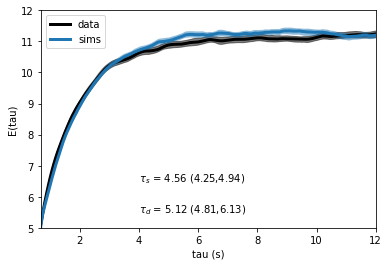

In [17]:
#there may be small fluctuations due to the finite sample size
#the figure in the manuscript used a higher number of samples
plt.plot(np.arange(wsize)*dt,mean_data,c='k',lw=3,label='data')
plt.fill_between(np.arange(wsize)*dt,cil_data,ciu_data,alpha=.5,color='k')
plt.plot(np.arange(wsize)*dt,mean,lw=3,label='sims')
plt.fill_between(np.arange(wsize)*dt,cil,ciu,alpha=.5)
plt.text(4,5.5,r'$\tau_d$ = {:.2f} ({:.2f},{:.2f})'.format(mean_tau_data,cil_tau_data,ciu_tau_data),fontsize=10)
plt.text(4,6.5,r'$\tau_s$ = {:.2f} ({:.2f},{:.2f})'.format(mean_tau_sim,cil_tau_sim,ciu_tau_sim),fontsize=10)
plt.xlim(11*dt,12)
plt.ylim(5,12)
plt.ylabel('E(tau)')
plt.xlabel('tau (s)')
plt.legend()
# plt.savefig('E_tau_nn_in_partition_vs_sim.pdf')
plt.show()

# example kymographs

In [18]:
eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in tseries_w])

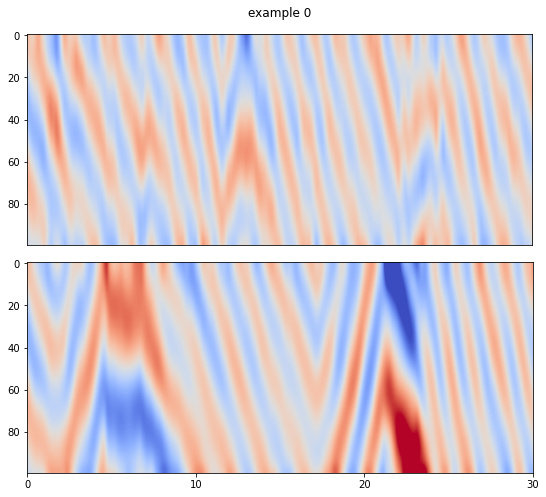

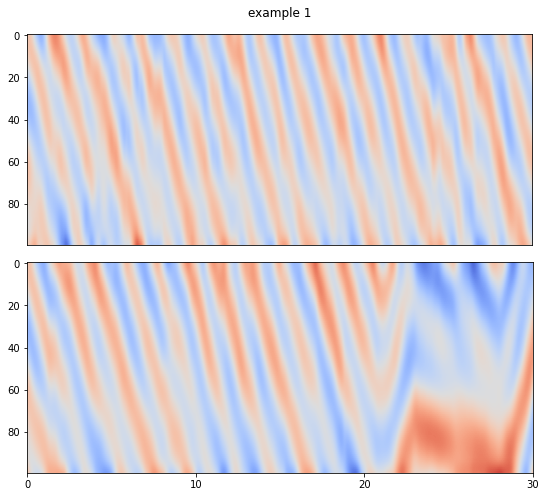

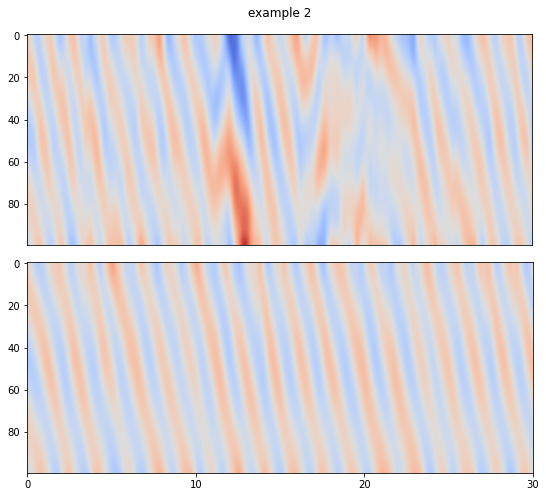

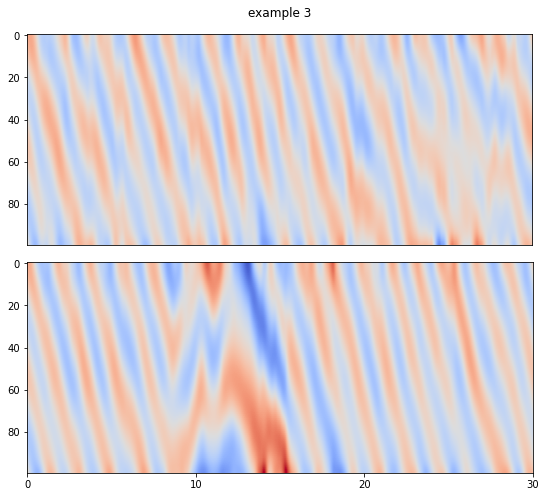

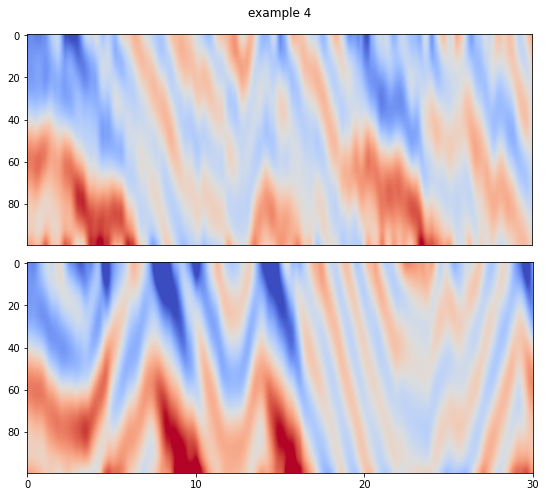

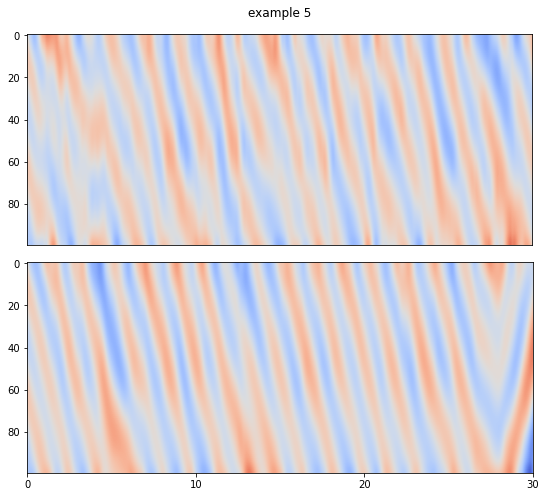

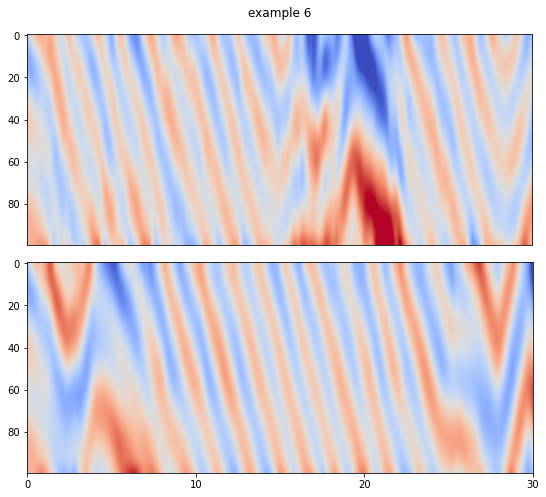

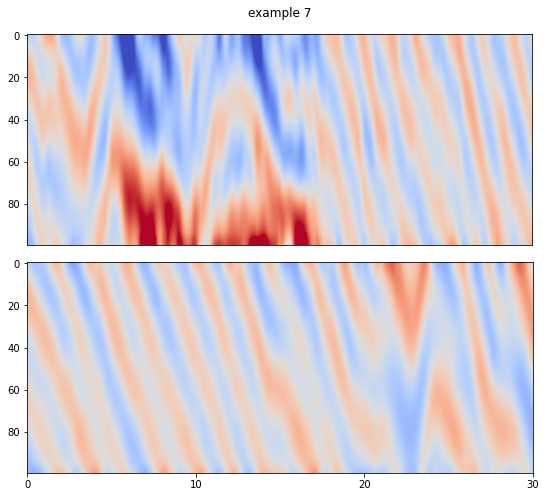

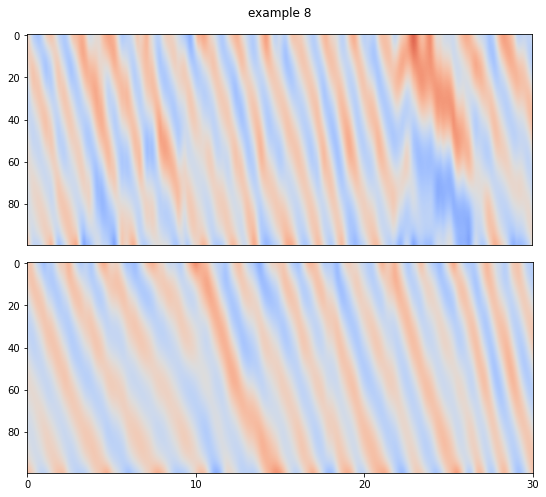

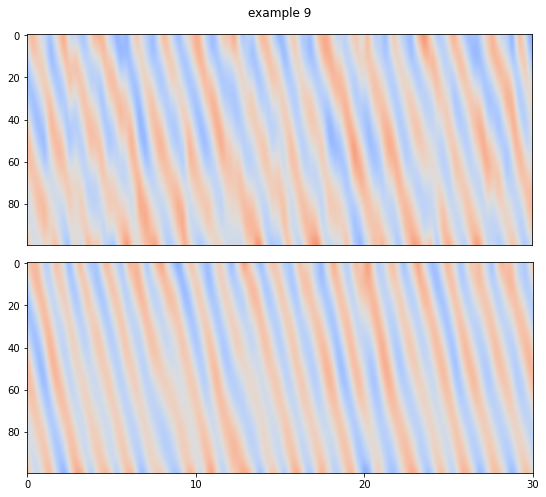

In [19]:
wsize = int(30*frameRate)
k=0
while k<10:
    kw = np.random.randint(n_worms)
    ks=np.random.randint(0,len(sim_interp_ts_w[kw]))
    f = h5py.File("../data/tseries_sims/tseries_sims_{}.h5".format(kw),'r')
    sim = ma.array(f['ts_smooth_sims'])[ks]
    sim_raw = ma.array(f['ts_sims'])[ks]
    f.close()
    sim[sim==0] = ma.masked
    sim_raw[sim_raw==0] = ma.masked

    sel = ~np.any(sim_raw.mask,axis=1)[:-wsize]
    possible_indices = np.arange(0,len(sim_raw)-wsize)[sel]

    t0=len(sim)
    while t0>len(sim)-wsize:
        sim_t0 = np.random.choice(possible_indices)
        ts0 = sim_raw[sim_t0]
        t0 = np.argmin(((tseries_w[kw]-ts0)**2).sum(axis=1))
    theta_sim = sim[sim_t0:sim_t0+wsize].dot(eigenworms_matrix[:,:5].T)
    theta_data = tseries_w[kw][t0:t0+wsize].dot(eigenworms_matrix[:,:5].T)
    
    if ma.count_masked(theta_data)==0:
        plt.figure(figsize=(10,7))
        plt.suptitle('example {}'.format(k))
        plt.subplot(2,1,1)
        plt.imshow(theta_sim.T,cmap='coolwarm',vmin=-np.pi,vmax=np.pi,aspect=2)
        plt.xticks([])
        plt.subplot(2,1,2)
        plt.imshow(theta_data.T,cmap='coolwarm',vmin=-np.pi,vmax=np.pi,aspect=2)
        plt.tight_layout()
        plt.xticks(np.arange(0,wsize+1,10*frameRate),np.arange(0,31,10))
#         plt.savefig('example_kymograph_{}.pdf'.format(k))
        plt.show()
        k+=1